DESCRIPTION: Basic Reproducible Research and Data Science

Use Jupyter with pandas to find some data on the Internet, pull it down, process it, and plot data points on a map.
The data comes in from online at:
* [global-power-plant-database](https://github.com/wri/global-power-plant-database/tree/master/source_databases_csv)

In [169]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt

import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)

In [170]:
# Read in some data from some data source into a data frame.
# We'll pull in the data for USA, Canada, Australia, Mexico, India, ...
list = []
for name in 'USA CAN AUS MEX IND BRA'.split():
    print(f"Loading {name}")
    url = f"https://raw.githubusercontent.com/wri/global-power-plant-database/master/source_databases_csv/database_{name}.csv"
    list.append(pd.read_csv(url))
df = pd.concat(list)        
df.index = df.reindex()

Loading USA
Loading CAN
Loading AUS
Loading MEX
Loading IND
Loading BRA


In [171]:
# Clean data by removing rows with bad coordinates
print('Before', len(df))
df = df[(-180 < df['latitude']) & (df['latitude'] < 180) & (-90 < df['longitude']) & (df['longitude'] < 90)]
print('After', len(df))

Before 19631
After 11340


In [172]:
# Short the columns and types of that data frame
df.dtypes

country                      object
country_long                 object
name                         object
gppd_idnr                    object
capacity_mw                 float64
latitude                    float64
longitude                   float64
primary_fuel                 object
other_fuel1                  object
other_fuel2                  object
other_fuel3                  object
commissioning_year          float64
owner                        object
source                       object
url                          object
geolocation_source           object
wepp_id                     float64
year_of_capacity_data       float64
generation_gwh_2013         float64
generation_gwh_2014         float64
generation_gwh_2015         float64
generation_gwh_2016         float64
generation_gwh_2017         float64
generation_gwh_2018         float64
generation_gwh_2019         float64
generation_data_source       object
estimated_generation_gwh    float64
dtype: object

In [173]:
# Show various summary statistics of each column:
df.describe()

,capacity_mw,latitude,longitude,commissioning_year,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,estimated_generation_gwh
count,11340.00,11340.00,11340.00,8453.00,0.0,10922.00,2919.00,3510.00,3753.00,4199.00,4499.00,4787.00,4775.00,0.0
mean,103.61,18.54,-56.33,2000.07,NaN,2018.03,677.38,833.18,801.69,701.88,670.15,643.52,471.16,NaN
std,367.06,27.62,40.66,22.54,NaN,1.59,2419.34,2664.82,2613.74,2476.59,2424.67,2376.54,1994.76,NaN
min,0.00,-33.72,-90.00,1900.00,NaN,2000.00,-947.60,-989.62,-864.43,-768.62,-934.94,-982.62,-780.34,NaN
25%,1.00,-12.95,-79.30,1994.00,NaN,2017.00,0.89,1.90,1.73,1.73,1.77,1.76,2.35,NaN
50%,4.70,34.75,-72.04,2009.00,NaN,2019.00,14.62,17.54,14.55,9.72,9.66,9.01,8.88,NaN
75%,28.00,41.54,-47.75,2014.00,NaN,2019.00,149.03,228.22,210.09,135.35,117.14,114.96,65.59,NaN
max,8535.00,90.00,88.87,2020.00,NaN,2019.00,26718.11,28127.00,30539.00,30015.00,35116.00,35136.00,29519.90,NaN


In [174]:
# Other column statistics
df.describe(include=object)

,country,country_long,name,gppd_idnr,primary_fuel,other_fuel1,other_fuel2,other_fuel3,owner,source,url,geolocation_source,generation_data_source
count,11340,11340,11340,11340,10348,962,176,70,6670,11340,11340,11340,5327
unique,5,5,11160,11340,14,12,11,9,3349,209,312,8,2
top,USA,United States of America,São José,USA0062781,Hydro,Oil,Oil,Gas,Cypress Creek Renewables,U.S. Energy Information Administration,http://www.eia.gov/electricity/data/browser/,U.S. Energy Information Administration,U.S. Energy Information Administration
freq,5792,5792,10,1,2319,662,49,27,159,5757,5757,5757,4911


In [175]:
# Some other things to try:
#df.head()
#df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11340 entries, ('USA', 'United States of America', '10 Briggs Solar NG  LLC (East)', 'USA0062781', 0.0, 41.6327, -71.4963, nan, nan, nan, nan, nan, '10 Briggs Solar NG  LLC', 'U.S. Energy Information Administration', 'http://www.eia.gov/electricity/data/browser/', 'U.S. Energy Information Administration', nan, 2019.0, nan, nan, nan, nan, nan, nan, nan, nan, nan) to ('BRA', 'Brazil', 'Índio Condá', 'BRA0029590', 2.9, -27.1382, -52.7004, 'Hydro', nan, nan, nan, 2015.0, nan, 'Agência Nacional de Energia Elétrica (Brazil)', 'http://www2.aneel.gov.br/aplicacoes/capacidadebrasil/capacidadebrasil.cfm', 'Agência Nacional de Energia Elétrica (Brazil)', nan, 2017.0, nan, nan, nan, nan, nan, nan, nan, nan, nan)
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   11340 non-null  object 
 1   country_long              11340 non-null  

In [176]:
# How many rows and shape?
print(f"""
Num rows: {len(df)}
Shape/Dimensions: {df.shape}
""")


Num rows: 11340
Shape/Dimensions: (11340, 27)



In [177]:
# Counts by country
df["country"].value_counts()

USA    5792
BRA    3897
IND     835
CAN     809
MEX       7
Name: country, dtype: int64

In [178]:
points = [Point(xy) for xy in zip(df.longitude, df.latitude)]
points[:5]

[<POINT (-71.496 41.633)>,
 <POINT (-73.983 41.093)>,
 <POINT (-80.843 36.284)>,
 <POINT (-80.552 36.217)>,
 <POINT (-80.656 36.148)>]

<AxesSubplot: >

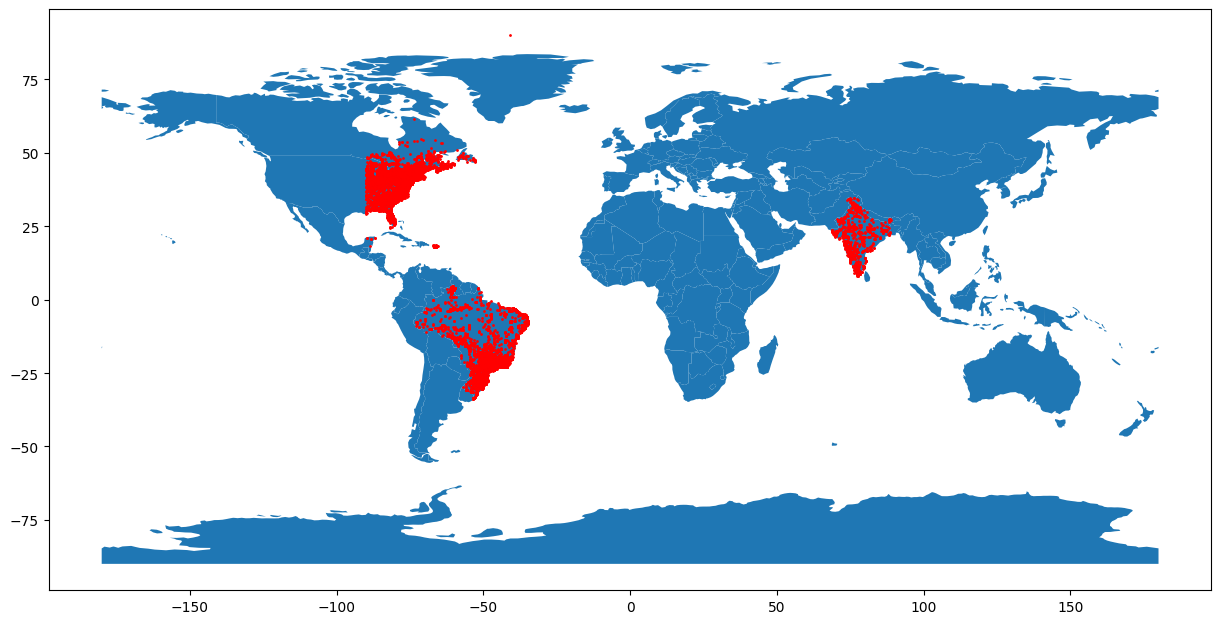

In [179]:
gdf = GeoDataFrame(df, geometry=points)
gdf.set_crs(epsg=4326, inplace=True)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 15)), aspect=1, marker='o', color='red', markersize=1)

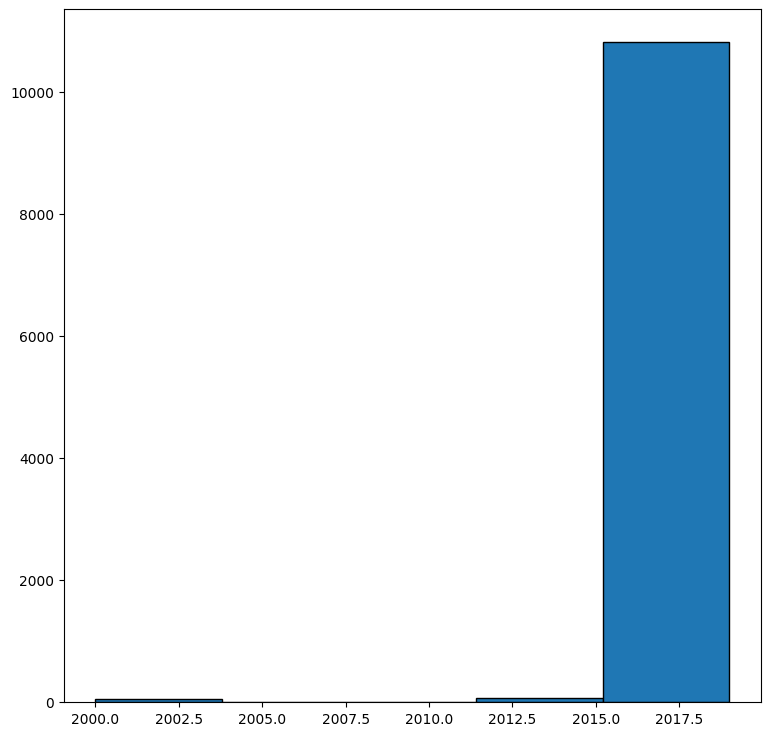

In [180]:
fig, ax = plt.subplots(figsize = (9, 9))
ax.hist(df["year_of_capacity_data"], bins=5, edgecolor="black");
